* **Students**: Miki Seltzer (miki.seltzer@berkeley.edu), Minhchau Dang (minhchau.dang@berkeley.edu)
* **Course**: 2016-0111 DATASCI W261: Machine Learning at Scale
* **Section**: Spring 2016, Section 2
* **Assignment**: Homework 5, Week 5
* **Submission Date**: February 18, 2016

In [ ]:
%matplotlib inline

This notebook requires some nbextensions.

* [toc2](https://github.com/ipython-contrib/IPython-notebook-extensions/tree/master/nbextensions/usability/toc2) provides a button to create a floating table of contents
* [toggle_all_line_numbers](https://github.com/ipython-contrib/IPython-notebook-extensions/tree/master/nbextensions/usability/toggle_all_line_numbers) provides a button to see line numbers for all code cells
* [autosaveclasses](https://github.com/holatuwol/jupyter-magic/tree/master/nbextensions/autosaveclasses.js) avoids usage of `%%writefile` (cells with a class definition are saved to disk when run)

If they are not yet installed, run the following cell and restart the notebook server.

In [ ]:
%%bash
mkdir -p .local/share/jupyter/nbextensions/

nbextdl() {
    mkdir -p $(ipython locate)/nbextensions/$(dirname $2)
    curl --silent -L \
        "https://raw.githubusercontent.com/$1/master/nbextensions/$2" \
        > "$(ipython locate)/nbextensions/$2"
}

nbextdl ipython-contrib/IPython-notebook-extensions usability/toc2/main.js
nbextdl ipython-contrib/IPython-notebook-extensions usability/toc2/main.css
nbextdl ipython-contrib/IPython-notebook-extensions usability/toc2/icon.png
nbextdl ipython-contrib/IPython-notebook-extensions usability/toc2/image.png

nbextdl ipython-contrib/IPython-notebook-extensions usability/toggle_all_line_numbers/main.js
nbextdl ipython-contrib/IPython-notebook-extensions usability/toggle_all_line_numbers/icon.png

nbextdl holatuwol/jupyter-magic autosaveclasses.js

Autoload the extensions.

In [ ]:
%%javascript
require(['base/js/utils'], function(utils) {
    utils.load_extensions('usability/toc2/main');
    utils.load_extensions('usability/toggle_all_line_numbers/main');
    utils.load_extensions('autosaveclasses');
});

<IPython.core.display.Javascript object>

Set the HDFS base folder.

In [ ]:
hdfs_base_folder = '/tmp'
runner = 'hadoop'

mapper_count = 10
reducer_count = 10

# HW 5.0

> What is a data warehouse?

A data warehouse is an enterprise data repository containing various sources of data, ranging from relational databases (such as sales transaction data) to semi-structured data files (such as logs) used for business intelligence and data science.

Data warehouses traditionally deal with high volume and high variety, but they are fed by various data pipelines in batch processes in order to support online analytics processing (OLAP) and so are not often high velocity like online transactions processing (OLTP) systems. This pipeline is depicted in an image from [datawarehouse4u.info](http://datawarehouse4u.info/).

![Data Warehouse Architecture](http://datawarehouse4u.info/images/data_warehouse_architecture.jpg)

Data warehouses have traditionally been used to feed dashboards and reports, but as business intelligence tools evolve, these systems are becoming more interactive with drill-down features such as pivot tables and data cubes.

> What is a Star schema? When is it used?

A star schema is a schema that relates a large fact table (the star schema) with multiple dimension tables (tables that contain the actual information, similar to what is used as measures in pivot tables). This relationship between fact tables and information schemas is depicted in an image in an old [knowledge base article](https://www-01.ibm.com/support/knowledgecenter/SSEPEK_10.0.0/com.ibm.db2z10.doc.perf/src/tpc/db2z_starschemaaccess.dita) for the IBM DB2 database.

![Star Schema](https://www-01.ibm.com/support/knowledgecenter/api/content/nl/en-us/SSEPEK_10.0.0/com.ibm.db2z10.doc.perf/src/art/bkn9p039.gif)

A star schema is used to organize the metadata of a relational database and facilitate joins of tables by providing information on which tables can be joined with which keys. They are applied when a query joining multiple tables must be materialized. Their design and application makes them similar to snowflake schemas, but star schemas are denormalized whereas snowflake schemas are normalized.

Multiple star schemas linked together (by sharing dimension tables) is known as a fact constellation, as described in the first lecture in [CSE 592 at Washington University](https://courses.cs.washington.edu/courses/cse592/01sp/lectures/).

![Fact Constellation](https://courses.cs.washington.edu/courses/cse592/01sp/lectures/class1/img033.jpg)

# HW 5.1

> In the database world, what is 3NF?

3NF is shorthand for third normal form. To further summarize [A Simple Guide to Five Normal Forms in Relational Database Theory](http://www.bkent.net/Doc/simple5.htm) by William Kent, a table is in third normal form if the following conditions hold:

* All records must contain the same number of fields (first normal form)
* If the table is described with a composite key, information in a column relates to the entire the key and not just one of the columns in the key (second normal form)
* The value column only provides more information relating directly relating to the key, and there is no transitive dependence between non-key columns in the table (third normal form)

The process of converting a non-conforming table into a conforming table is referred to as normalization. One normalization process is depicted in a training slides for the [Geographic Information Technology Training Alliance](http://www.gitta.info/LogicModelin/en/html/DataConsiten_Norm3NF.html).

![3NF Normalization](http://www.gitta.info/LogicModelin/en/image/3NF.gif)

> Does machine learning use data in 3NF? If so why?

ML may pull data from data warehouses that have relational databases managed by DBAs concerned with 3NF, but using such a data source is not required by ML.

It is desirable to use a 3NF data source because it can save a significant amount of disk space because data duplication is avoided. Additionally, when data is denormalized, then fields in the data set might be related to each other and create record update dependencies. This may be problematic if we are using algorithms that rely on consistent data and feature independence.

> In what form does ML consume data?

ML requires examining many features and attributes that are potentially stored across a variety of systems. In this examination, ML ultimately consumes any data that can be provided by a data warehouse. As described in a slide from a presentation at a [cognitive computing meetup](http://www.slideshare.net/SaiDevulapalli/machine-learning-use-cases-in-telecom), this means that ML data sources are extremely diverse and ML may wind up looking at data stored in a wide variety of formats.

![Data Sources and Use Cases](http://image.slidesharecdn.com/cognitivemeetupjul2014saislidesver2-140717075405-phpapp01/95/machine-learning-use-cases-in-telecom-cognitive-computing-meetup-4-638.jpg?cb=1405583739)

In other words, ML may consume data that is in 3NF but it also consumes data on denormalized views resulting from joins of 3NF normalized tables or even data that is not normalized at all. However, since it's looking at a variety of features at once, the easiest way for ML to ingest data in a parallel way is for it to already be denormalized.

> Why would one use log files that are denormalized?

When running the algorithms, ML algorithms perform better if the data is already prepared in what the ML system perceives to be a single data source, even if the data is actually originating from multiple systems. One way to achieve that is through a log system architecture described in a blog by Jay Kreps from LinkedIn titled [The Log: What every software engineer should know about real-time data's unifying abstraction](https://engineering.linkedin.com/distributed-systems/log-what-every-software-engineer-should-know-about-real-time-datas-unifying).

Another reason is to treat the data as schema on read rather than schema on write, allowing ML to ingest mostly raw logs before they have been transformed. As noted in the async lectures, this provides analytics tools with the flexibility difference of using ELT rather than ETL processes, though potentially with a slight performance penalty.

Additionally, if one needs to perform real-time analysis on log files, it may be too time consuming to join normalized log data in one log table with normalized log data in other tables. If log files are denormalized, they may not need any further processing (joins) to be fed into other steps of a pipeline, thus improving performance.

# HW 5.2

> Using MRJob, implement a hashside join (memory-backed map-side) for left,
right and inner joins. Run your code on the  data used in HW 4.4.

> (Recall HW 4.4: Find the most frequent visitor of each page using mrjob and the output of 4.2  (i.e., transformed log file). In this output please include the webpage URL, webpageID and Visitor ID.)

## Download 4.4 data

In [ ]:
!wget --quiet https://www.dropbox.com/sh/m0nxsf4vs5cyrp2/AADCHtrJ4CBCDO1po_OAWg0ia/anonymous-msweb.data

## Transform 4.4 data

In [ ]:
import os
from csv import reader

input_file_name = 'anonymous-msweb.data'

visitor_file_name = input_file_name + '.visitor'
visitor_file = open(visitor_file_name, 'w')

webpage_file_name = input_file_name + '.webpage'
webpage_file = open(webpage_file_name, 'w')

with open(input_file_name) as input_file:
    case_id = None

    # Update the case ID when we see a new case (line with a C).
    # Output the vote when we see a new vote (line with a V).
    # Add the 'A' lines to the web page file.

    for row in reader(input_file):
        if row[0] == 'A':
            print >> webpage_file, ','.join(row)
            continue

        if row[0] == 'C':
            case_id = row[1]
            continue

        if row[0] == 'V':
            row.extend(['C', case_id])
            print >> visitor_file, ','.join(row)

visitor_file.close()
webpage_file.close()

!hdfs dfs -copyFromLocal $visitor_file_name $hdfs_base_folder

copyFromLocal: `/tmp/anonymous-msweb.data.visitor': File exists


## Create 5.2 job

In [ ]:
from mrjob.job import MRJob
from mrjob.step import MRStep

import csv
import sys

class WebPageHashJoin(MRJob):

    """
    Allow join type to be passed through as a configuration option.
    """
    def configure_options(self):
        super(WebPageHashJoin, self).configure_options()
        self.add_passthrough_option('--join-type', type = 'string', default = 'left')

    """
    Load the web page data into memory to be the left table.
    """
    def mapper_init(self):
        self.vroot_data = {}
        self.seen_vroots = set()

        with open('anonymous-msweb.data.webpage', 'r') as webpage_file:
            for row in csv.reader(webpage_file):
                if len(row) != 5:
                    continue

                vroot_id = row[1]
                vroot_datum = [row[0]] + row[2:]
                self.vroot_data[vroot_id] = vroot_datum

    """
    Mapper for outer joins which only yields the join result if both results are
    not None.
    """
    def mapper_inner_join(self, _, line):
        vroot_id, left_result, right_result = self.get_join_row(line)

        if left_result is not None and right_result is not None:
            yield vroot_id, (left_result, right_result)

    """
    Mapper for outer joins which always yields the join result.
    """
    def mapper_outer_join(self, _, line):
        vroot_id, left_result, right_result = self.get_join_row(line)

        self.seen_vroots.add(vroot_id)

        yield vroot_id, (left_result, right_result)

    """
    Look up the web page data based on the vroot and combine with row.
    """
    def get_join_row(self, line):
        row = csv.reader([line]).next()

        vroot_id = row[1]

        if vroot_id in self.vroot_data:
            vroot_datum = self.vroot_data[vroot_id]
        else:
            vroot_datum = None

        visit_datum = [row[0]] + row[2:]

        return vroot_id, vroot_datum, visit_datum

    """
    Mapper finalizer which ensures that all values for the left table are emitted.
    Should only be used with a left outer join.
    """
    def mapper_final_left_join(self):
        for vroot_id, vroot_datum in self.vroot_data.iteritems():
            if vroot_id in self.seen_vroots:
                continue

            yield vroot_id, (vroot_datum, None)

    """
    Reducer finds the most frequent visitor for the given vroot.
    """
    def reducer(self, vroot_id, join_rows):
        none_row = None
        regular_row = False

        # Emit any non-none rows, because none rows could come from multiple reducers
        # and might not be valid output.

        for join_row in join_rows:
            if join_row[0] is None or join_row[1] is None:
                none_row = join_row
                continue

            regular_row = True
            yield vroot_id, join_row

        # If we never found a non-none row, then emit the none row.

        if not regular_row:
            yield vroot_id, none_row

    """
    Build out different steps depending on the join type.
    """
    def steps(self):
        # Inner join just needs the hash join initialization and uses the
        # inner join mapper.

        if self.options.join_type == 'inner':
            step = MRStep(
                mapper_init = self.mapper_init,
                mapper = self.mapper_inner_join,
                reducer = self.reducer)

        # Left join needs to emit keys at the end for anything that was not
        # seen in the input and uses the outer join mapper.

        elif self.options.join_type == 'left':
            step = MRStep(
                mapper_init = self.mapper_init,
                mapper = self.mapper_outer_join,
                mapper_final = self.mapper_final_left_join,
                reducer = self.reducer)

        # Right join just needs the hash join initialization and otherwise
        # uses the outer join mapper.

        else:
            step = MRStep(
                mapper_init = self.mapper_init,
                mapper = self.mapper_outer_join,
                reducer = self.reducer)

        return [step]

if __name__ == '__main__' and sys.argv[0].find('ipykernel') == -1:
    WebPageHashJoin().run()

> Justify which table you chose as the Left table in this hashside join.

I chose the web page table as the left table in this mapper-side hash join because it was the smaller of the two tables.

> Please report the number of rows resulting from:

Create a utility function to report the row counts by using `wc` on the output folder.

In [ ]:
def report_join_row_count(join_type):
    problem_id = 'mrjob_52_' + join_type
    mrjob_status_file = 'mrjob_52_' + join_type + '_progress.txt'

    !python WebPageHashJoin.py -r local \
        --hadoop-version=2.7.1 \
        --strict-protocols \
        --join-type=$join_type \
        --output-dir=$hdfs_base_folder/$problem_id \
        --no-output \
        --file anonymous-msweb.data.webpage \
        anonymous-msweb.data.visitor \
        > $mrjob_status_file 2>&1

    !wc -l $hdfs_base_folder/$problem_id/* | tail -1

> (1) Left joining Table Left with Table Right

In [ ]:
%time report_join_row_count('left')

  98663 total
CPU times: user 218 ms, sys: 30.2 ms, total: 248 ms
Wall time: 1min 2s


> (2) Right joining Table Left with Table Right

In [ ]:
%time report_join_row_count('right')

  98654 total
CPU times: user 143 ms, sys: 24 ms, total: 167 ms
Wall time: 41.8 s


> (3) Inner joining Table Left with Table Right

In [ ]:
%time report_join_row_count('inner')

  98654 total
CPU times: user 27.3 ms, sys: 6.34 ms, total: 33.6 ms
Wall time: 9.84 s


# HW 5.3

## Download ngrams data

> A large subset of the Google n-grams dataset

> https://aws.amazon.com/datasets/google-books-ngrams/

> which we have placed in a bucket/folder on Dropbox on s3:

> * https://www.dropbox.com/sh/tmqpc4o0xswhkvz/AACUifrl6wrMrlK6a3X3lZ9Ea?dl=0
> * s3://filtered-5grams/

> This bucket contains (~200) files (10Meg each) in the format:

> ```
    (ngram) \t (count) \t (pages_count) \t (books_count)
```

In [ ]:
import os

# Download the ngrams data set.

if not os.path.isdir('ngrams'):
    !mkdir ngrams
    !aws s3 sync --quiet s3://filtered-5grams/ ngrams/
    !hdfs dfs -copyFromLocal ngrams $hdfs_base_folder

## Create first10 data

For HW 5.3-5.5, for the Google n-grams dataset unit test and regression test your code using the
first 10 lines of the following file:

    googlebooks-eng-all-5gram-20090715-0-filtered.txt

Once you are happy with your test results proceed to generating your results on the Google n-grams dataset.

In [ ]:
import os

# Use the first 10 lines of the first file for unit testing.

if not os.path.isdir('first10'):
    !mkdir first10
    !head -10 ngrams/googlebooks-eng-all-5gram-20090715-0-filtered.txt > first10/test.txt
    !hdfs dfs -copyFromLocal first10 $hdfs_base_folder

## Data set switch function

In [ ]:
def run_job(python_args, problem_id, data_set, input_folder):

    # Use the notebook variables

    global runner
    global hdfs_base_folder

    # Determine the input folder based on job type

    if runner == 'hadoop':
        input_folder = 'hdfs://' + hdfs_base_folder + '/' + input_folder

    # Create a new output folder for each problem + data set pair

    if runner == 'hadoop':
        !hdfs dfs -mkdir -p $hdfs_base_folder/$problem_id
        !hdfs dfs -rm -r -f -skipTrash $hdfs_base_folder/$problem_id/$data_set > /dev/null
    else:
        !mkdir -p $hdfs_base_folder/$problem_id
        !rm -rf $hdfs_base_folder/$problem_id/$data_set

    # Run the program

    mrjob_status_file = problem_id + '_progress.txt'

    !python $python_args \
        -r $runner \
        --hadoop-version=2.7.1 \
        --strict-protocols \
        --output-dir=$hdfs_base_folder/$problem_id/$data_set \
        --no-output \
        --jobconf mapreduce.job.maps=$mapper_count \
        --jobconf mapreduce.job.reduces=$reducer_count \
        $input_folder \
        > $mrjob_status_file 2>&1

def save_job_output(problem_id, data_set, file_name):

    # Use the notebook variables

    global hdfs_base_folder

    # Print the desired output

    if runner == 'hadoop':
        !hdfs dfs -cat $hdfs_base_folder/$problem_id/$data_set/* > $file_name
    elif runner == 'local':
        !cat $hdfs_base_folder/$problem_id/$data_set/* > $file_name

# HW 5.3.1

> Do some EDA on this dataset using mrjob: Longest 5-gram (number of characters)

Since we're doing data exploration, we can avoid the single reducer problem as well as the strange Hadoop combiner sort bug by emitting one value per reducer and then doing a simple sort of the output files.

## Create 5.3.1 job

In [ ]:
import sys

from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.protocol import RawProtocol

class LongestNGram(MRJob):
    INPUT_PROTOCOL = RawProtocol

    """
    Yield the NGram itself and its length.
    """
    def mapper(self, ngram, _):
        ngram_length = len(ngram)
        yield None, (ngram_length, ngram)

    """
    Yield the longest ngram from the incoming pairs.
    """
    def combiner(self, _, pairs):
        yield None, self.get_longest_ngram(pairs)

    """
    Yield the longest ngram from the incoming pairs.
    """
    def reducer(self, _, pairs):
        ngram_length, ngram = self.get_longest_ngram(pairs)
        yield ngram_length, ngram

    """
    Identify the longest ngram. In the case of ties, it doesn't matter which
    one wins, so we'll choose the first one alphabetically.
    """
    def get_longest_ngram(self, pairs):
        longest_ngram = None
        longest_ngram_length = 0

        for ngram_length, ngram in pairs:
            if ngram_length > longest_ngram_length:
                longest_ngram = ngram
                longest_ngram_length = ngram_length
            elif ngram_length == longest_ngram_length and ngram < longest_ngram:
                longest_ngram = ngram

        return longest_ngram_length, longest_ngram

if __name__ == '__main__' and sys.argv[0].find('ipykernel') == -1:
    LongestNGram().run()

## Run 5.3.1 job

In [ ]:
%time run_job('LongestNGram.py', 'mrjob_531', 'ngrams', 'ngrams')

CPU times: user 486 ms, sys: 59.3 ms, total: 545 ms
Wall time: 2min 31s


In [ ]:
save_job_output('mrjob_531', 'ngrams', 'mrjob_531_output.txt')
!sort -k1nr 'mrjob_531_output.txt' | head -1

159	"AIOPJUMRXUYVASLYHYPSIBEMAPODIKR UFRYDIUUOLBIGASUAURUSREXLISNAYE RNOONDQSRUNSUBUNOUGRABBERYAIRTC UTAHRAPTOREDILEIPMILBDUMMYUVERI SYEVRAHVELOCYALLOSAURUSLINROTSR"


# HW 5.3.2

> Do some EDA on this dataset using mrjob: Top 10 most frequent words (please use the count information), i.e., unigrams

Since we're doing data exploration, we can avoid the single reducer problem as well as the strange Hadoop combiner sort bug by emitting one value per reducer and then doing a simple sort of the output files.

## Create 5.3.2 job

In [ ]:
import sys

from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.protocol import RawProtocol

class MostFrequentUnigrams(MRJob):
    INPUT_PROTOCOL = RawProtocol

    """
    Yield the word counts.
    """
    def mapper(self, doc_id, value):
        doc_id = doc_id.lower()

        split_value = value.split('\t')
        ngram_count = int(split_value[0])

        word_counts = {}

        for word in doc_id.split(' '):
            if word in word_counts:
                word_counts[word] += ngram_count
            else:
                word_counts[word] = ngram_count

        for word, count in word_counts.iteritems():
            yield word, count

    """
    Yield the summed word counts.
    """
    def combiner(self, word, counts):
        yield word, sum(counts)

    """
    Yield the summed word counts.
    """
    def reducer(self, word, counts):
        yield word, sum(counts)

if __name__ == '__main__' and sys.argv[0].find('ipykernel') == -1:
    MostFrequentUnigrams().run()

## Run 5.3.2 job

In [ ]:
%time run_job('MostFrequentUnigrams.py', 'mrjob_532', 'ngrams', 'ngrams')

CPU times: user 952 ms, sys: 164 ms, total: 1.12 s
Wall time: 5min 50s


In [ ]:
save_job_output('mrjob_532', 'ngrams', 'mrjob_532_output.txt')
!sort -k2nr -k1 mrjob_532_output.txt > mrjob_532_output_sorted.txt

In [ ]:
!head -10 mrjob_532_output_sorted.txt

"the"	5490815394
"of"	3698583299
"to"	2227866570
"in"	1421312776
"a"	1361123022
"and"	1149577477
"that"	802921147
"is"	758328796
"be"	688707130
"as"	492170314


# HW 5.3.3

> Do some EDA on this dataset using mrjob: 20 Most/Least densely appearing words (count/pages_count) sorted in decreasing order of relative frequency

Since we're doing data exploration, we can avoid the single reducer problem as well as the strange Hadoop combiner sort bug by emitting one value per reducer and then doing a simple sort of the output files.

## Create 5.3.3 job

In [ ]:
import sys

from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.protocol import RawProtocol

class MostDenselyAppearingWords(MRJob):
    INPUT_PROTOCOL = RawProtocol

    """
    Yield the word counts and page counts.
    """
    def mapper(self, doc_id, value):
        doc_id = doc_id.lower()

        split_value = value.split('\t')
        ngram_count = int(split_value[0])
        page_count = int(split_value[1])

        word_counts = {}

        for word in doc_id.split(' '):
            if word in word_counts:
                word_counts[word] += ngram_count
            else:
                word_counts[word] = ngram_count

        for word, count in word_counts.iteritems():
            yield word, (count, page_count)

    """
    Yield the summed word counts and page counts.
    """
    def combiner(self, word, pairs):
        yield word, self.get_pairs_sum(pairs)

    """
    Yield the summed word counts and page counts.
    """
    def reducer(self, word, pairs):
        total_word_count, total_page_count = self.get_pairs_sum(pairs)

        yield word, float(total_word_count) / float(total_page_count)

    """
    Yield the summed word counts and page counts.
    """
    def get_pairs_sum(self, pairs):
        total_word_count = 0
        total_page_count = 0

        for word_count, page_count in pairs:
            total_word_count += word_count
            total_page_count += page_count

        return (total_word_count, total_page_count)

if __name__ == '__main__' and sys.argv[0].find('ipykernel') == -1:
    MostDenselyAppearingWords().run()

## Run 5.3.3 job

In [ ]:
%time run_job('MostDenselyAppearingWords.py', 'mrjob_533', 'ngrams', 'ngrams')

CPU times: user 1.02 s, sys: 156 ms, total: 1.17 s
Wall time: 5min 46s


In [ ]:
save_job_output('mrjob_533', 'ngrams', 'mrjob_533_output.txt')
!sort -k1nr -k2 mrjob_533_output.txt > mrjob_533_output_sorted.txt

In [ ]:
!head -20 mrjob_533_output_sorted.txt

57.786458333333336	"xxxx"
37.666666666666664	"nnn"
30.60614934114202	"blah"
24.609375	"oooooooooooooooo"
22.558139534883722	"llll"
18.963547995139734	"oooooo"
17.5	"xxxxxxxx"
16.635396724101255	"ooooo"
11.290476190476191	"choh"
10.034392999556934	"na"
9.965657249196413	"nd"
9.395604395604396	"iooo"
8.306397306397306	"illl"
6.107142857142857	"neg"
5.357142857142857	"oooooooo"
4.8193146417445485	"iiii"
4.216117216117216	"vir"
4.106772422208664	"nn"
3.9881422924901186	"ome"
3.9573934837092732	"beep"


In [ ]:
!tail -20 mrjob_533_output_sorted.txt

1.0	"zwingst"
1.0	"zwirnen"
1.0	"zwischenstaatlicher"
1.0	"zwitterionic"
1.0	"zwt"
1.0	"zwyn"
1.0	"zx"
1.0	"zxcvframeqasfuc"
1.0	"zydeco"
1.0	"zydom"
1.0	"zygmunt"
1.0	"zygomaticofacial"
1.0	"zygomaticotemporal"
1.0	"zygosity"
1.0	"zylindrischen"
1.0	"zymelman"
1.0	"zymogens"
1.0	"zymophore"
1.0	"zymosan"
1.0	"zymosis"


# HW 5.3.4

> Do some EDA on this dataset using mrjob: Distribution of 5-gram sizes (character length).  E.g., count (using the count field) up how many times a 5-gram of 50 characters shows up. Plot the data graphically using a histogram.

## Create 5.3.4 job

In [ ]:
import sys

from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.protocol import RawProtocol

class NGramLengthCounts(MRJob):
    INPUT_PROTOCOL = RawProtocol

    """
    Yield the length and the count.
    """
    def mapper(self, ngram, value):
        ngram_length = len(ngram)

        split_value = value.split('\t')
        ngram_count = int(split_value[0])

        yield ngram_length, ngram_count

    """
    Yield the summed counts.
    """
    def combiner(self, ngram_length, counts):
        yield ngram_length, sum(counts)

    """
    Yield the summed counts.
    """
    def reducer(self, ngram_length, counts):
        yield ngram_length, sum(counts)

if __name__ == '__main__' and sys.argv[0].find('ipykernel') == -1:
    NGramLengthCounts().run()

## Run 5.3.4 job

In [ ]:
%time run_job('NGramLengthCounts.py', 'mrjob_534', 'ngrams', 'ngrams')

CPU times: user 553 ms, sys: 73.7 ms, total: 627 ms
Wall time: 2min 32s


In [ ]:
save_job_output('mrjob_534', 'ngrams', 'mrjob_534_output.txt')

## Plot length histogram

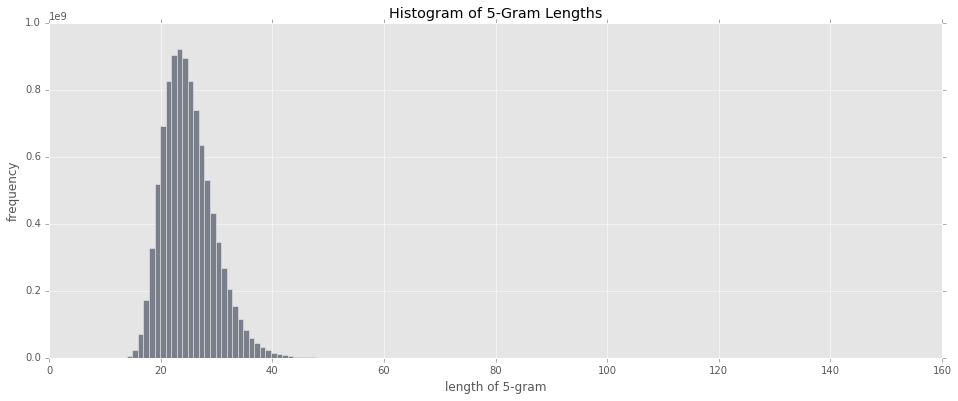

In [ ]:
import csv
import matplotlib

matplotlib.style.use('ggplot')
length_frequencies = []

# Build up the frequencies manually, because there may be gaps in the input
# that we need to fill in with zeroes.

with open('mrjob_534_output.txt', 'r') as output_file:
    for row in csv.reader(output_file, delimiter = '\t'):
        index = int(row[0])

        for i in range(len(length_frequencies), index + 1):
            length_frequencies.append(0)

        length_frequencies[index] = int(row[1])

# Create a histogram using matplotlib.

bin_count = len(length_frequencies)

matplotlib.pyplot.figure(figsize=(16, 6))
matplotlib.pyplot.xlabel("length of 5-gram")
matplotlib.pyplot.ylabel("frequency")
matplotlib.pyplot.title("Histogram of 5-Gram Lengths")
matplotlib.pyplot.hist(range(0, bin_count), bin_count, weights = length_frequencies, color='#797f8b');

# HW 5.3.5 (Optional)

> Plot the log-log plot of the frequency distribution of unigrams. Does it follow power law distribution?

> For more background see:

> * https://en.wikipedia.org/wiki/Log%E2%80%93log_plot
> * https://en.wikipedia.org/wiki/Power_law

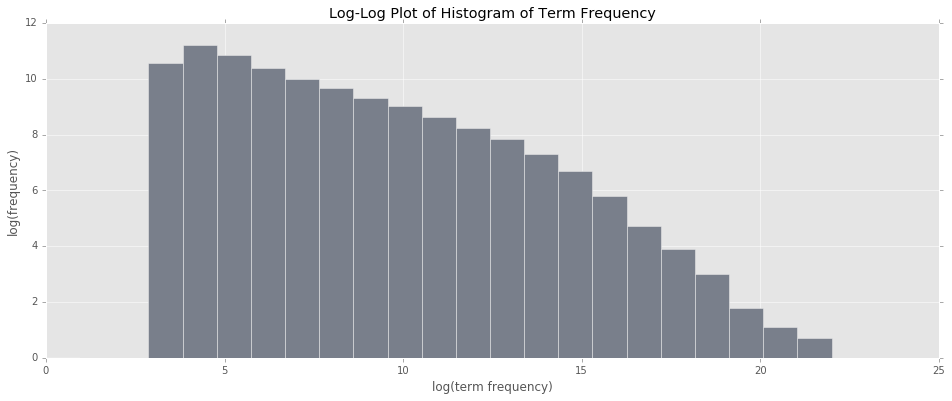

In [ ]:
import csv
import math
import matplotlib

matplotlib.style.use('ggplot')
unigram_frequencies = []

# Build up the frequencies manually, because there may be gaps in the input
# that we need to fill in with zeroes.

with open('mrjob_532_output.txt', 'r') as output_file:
    for row in csv.reader(output_file, delimiter = '\t'):
        log_index = int(math.log(int(row[1])))

        for i in range(len(unigram_frequencies), log_index + 1):
            unigram_frequencies.append(0)

        unigram_frequencies[log_index] += 1

log_unigram_frequencies = [math.log(x) if x != 0 else 0 for x in unigram_frequencies]

# Create a histogram using matplotlib.

bin_count = len(log_unigram_frequencies)

matplotlib.pyplot.figure(figsize=(16, 6))
matplotlib.pyplot.xlabel('log(term frequency)')
matplotlib.pyplot.ylabel('log(frequency)')
matplotlib.pyplot.title('Log-Log Plot of Histogram of Term Frequency')
matplotlib.pyplot.hist(range(0, bin_count), bin_count, weights = log_unigram_frequencies, color='#797f8b');

As noted in the [graphical methods for identification](https://en.wikipedia.org/wiki/Power_law#Graphical_methods_for_identification) section of the linked Wikipedia article, since the log-log plot is very close to a straight downward-sloped line, this is strong evidence that the original values follow a power law distribution.

# HW 5.4

> For the remainder of this assignment you will work with two datasets:

> (1) unit/systems test data set: SYSTEMS TEST DATASET

> Three terms, A,B,C and their corresponding strip-docs of co-occurring terms

>```
    DocA {X:20, Y:30, Z:5}
    DocB {X:100, Y:20}
    DocC {M:5, N:20, Z:5}
```

> (2) A large subset of the Google n-grams dataset as was described above

> In this part of the assignment we will focus on developing methods
for detecting synonyms, using the Google 5-grams dataset.

## Create unit test data

In [ ]:
!mkdir -p unit

In [ ]:
%%writefile unit/test.txt
DocA	{'X':20, 'Y':30, 'Z':5}
DocB	{'X':100, 'Y':20}
DocC	{'M':5, 'N':20, 'Z':5}

Writing unit/test.txt


In [ ]:
!hdfs dfs -copyFromLocal unit $hdfs_base_folder

# HW 5.4.1

> (1) Build stripes for the most frequent 10,000 words using cooccurence information based on
the words ranked from 1001,-10,000 as a basis/vocabulary (drop stopword-like terms),
and output to a file in your bucket on s3 (bigram analysis, though the words are non-contiguous).

> **Design Notes**

> For this task you will be able to modify the pattern we used in HW 3.2
(feel free to use the solution as reference). To total the word counts
across the 5-grams, output the support from the mappers using the total
order inversion pattern:

> ```
    <*word,count>
```

> to ensure that the support arrives before the cooccurrences.

> In addition to ensuring the determination of the total word counts,
the mapper must also output co-occurrence counts for the pairs of
words inside of each 5-gram. Treat these words as a basket,
as we have in HW 3, but count all stripes or pairs in both orders,
i.e., count both orderings: (word1,word2), and (word2,word1), to preserve
symmetry in our output for (2).

## Create dictionary file

We already generated the dictionary as part of our exploratory data analysis. Extract the dictionary here.

In [ ]:
!head -10000 mrjob_532_output_sorted.txt > ngrams_vocabulary.txt
!head -10000 mrjob_532_output_sorted.txt | tail -1000 > ngrams_basis.txt

## Create 5.4.1 job

In [ ]:
import csv
import sys

from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.protocol import RawProtocol

class StripedNGrams(MRJob):
    INPUT_PROTOCOL = RawProtocol

    """
    Load the valid dictionary terms.
    """
    def mapper_init(self):
        self.basis = set()
        self.vocabulary = set()

        with open('ngrams_basis.txt', 'r') as basis_file:
            self.basis = set([row[0] for row in csv.reader(basis_file, delimiter = '\t')])

        with open('ngrams_vocabulary.txt', 'r') as vocabulary_file:
            self.vocabulary = set([row[0] for row in csv.reader(vocabulary_file, delimiter = '\t')])

    """
    Yield the per-document stripes.
    """
    def mapper(self, ngram, value):
        ngram = ngram.lower()

        # Parse the word counts separately based on whether we are checking the
        # unit test data or the actual ngrams data.

        if value[0] == '{':
            word_counts = eval(value)
            self.basis.update(word_counts.keys())
        else:
            split_value = value.split('\t')
            ngram_count = int(split_value[0])

            word_counts = {}

            for word in ngram.split(' '):
                if word not in self.vocabulary:
                    continue

                if word in word_counts:
                    word_counts[word] += ngram_count
                else:
                    word_counts[word] = ngram_count

        # Emit all the stripes derived from the word count. Only include keys
        # in the stripe if the key is in the basis.

        if len(word_counts) < 2:
            return

        for word, count in word_counts.iteritems():
            stripe = {
                key: value for key, value in word_counts.iteritems()
                    if key != word and key in self.basis
            }

            if len(stripe) == 0:
                continue

            stripe['*'] = count

            yield word, stripe

    """
    Sum the stripes.
    """
    def combiner(self, word, stripes):
        yield word, self.combine_stripes(stripes)

    """
    Sum the stripes and then emit the coccurrence rate.
    """
    def reducer(self, word, stripes):
        combined_stripe = self.combine_stripes(stripes)
        total_count = combined_stripe['*']

        rate_stripe = {
            key: float(value) / total_count
                for key, value in combined_stripe.iteritems() if key != '*'
        }

        yield word, rate_stripe

    """
    Sum the stripes.
    """
    def combine_stripes(self, stripes):
        combined_stripe = {}

        for stripe in stripes:
            for key, value in stripe.iteritems():
                if key in combined_stripe:
                    combined_stripe[key] += value
                else:
                    combined_stripe[key] = value

        return combined_stripe

if __name__ == '__main__' and sys.argv[0].find('ipykernel') == -1:
    StripedNGrams().run()

## Run 5.4.1 unit test

> Please unit test and system test your code with with SYSTEMS TEST DATASET and show the results. Please compute the expected answer by hand and show your hand calculations. Then show the results you get with your system.

We have the following data set for the data set:

    DocA	{X:20, Y:30, Z:5}
    DocB	{X:100, Y:20}
    DocC	{M:5, N:20, Z:5}

This yields the following per-document stripes, sorted by word:

    M	{*:5, N:20, Z:5}
    N	{*:20, M:5, Z:5}
    X	{*:20, Y:30, Z:5}
    X	{*:100, Y:20}
    Y	{*:30, X:20, Z:5}
    Y	{*:20, X:100}
    Z	{*:5, X:20, Y:30}
    Z	{*:5, M:5, N:20}

If we sum them, this yields the following stripes:

    M	{*:5, N:20, Z:5}
    N	{*:20, M:5, Z:5}
    X	{*:120, Y:50, Z:5}
    Y	{*:50, X:120, Z:5}
    Z	{*:10, M:5, N:20, X:20, Y:30}

This results in the following final cooccurences:

    M	{N:20/5, Z:5/5}
    N	{M:5/20, Z:5/20}
    X	{Y:50/120, Z:5/120}
    Y	{X:120/50, Z:5/50}
    Z	{M:5/10, N:20/10, X:20/10, Y:30/10}

In [ ]:
%time run_job(
    'StripedNGrams.py --file ngrams_basis.txt --file ngrams_vocabulary.txt',
    'mrjob_541', 'unit', 'unit')

CPU times: user 157 ms, sys: 26.1 ms, total: 183 ms
Wall time: 53.3 s


In [ ]:
save_job_output('mrjob_541', 'unit', 'mrjob_541_unit_output.txt')
!cat 'mrjob_541_unit_output.txt'

"M"	{"Z": 1.0, "N": 4.0}
"N"	{"Z": 0.25, "M": 0.25}
"X"	{"Y": 0.4166666666666667, "Z": 0.041666666666666664}
"Y"	{"X": 2.4, "Z": 0.1}
"Z"	{"Y": 3.0, "X": 2.0, "M": 0.5, "N": 2.0}


## Run 5.4.1 ngrams

> Finally show your results on the Google n-grams dataset

In [ ]:
%time run_job(
    'StripedNGrams.py --file ngrams_basis.txt --file ngrams_vocabulary.txt',
    'mrjob_541', 'ngrams', 'ngrams')

CPU times: user 666 ms, sys: 60.2 ms, total: 726 ms
Wall time: 2min 58s


In [ ]:
save_job_output('mrjob_541', 'ngrams', 'mrjob_541_ngrams_output.txt')
!wc -l mrjob_541_ngrams_output.txt

9994 mrjob_541_ngrams_output.txt


# HW 5.4.2

> In this part of the assignment we will focus on developing methods
for detecting synonyms, using the Google 5-grams dataset.

> (2) Using two (symmetric) comparison methods of your choice
(e.g., correlations, distances, similarities), pairwise compare
all stripes (vectors), and output to a file in your bucket on s3.

> **Design Notes**

> For this task you will have to determine a method of comparison.
Here are a few that you might consider:

> * Jaccard
> * Cosine similarity
> * Spearman correlation
> * Euclidean distance
> * Taxicab (Manhattan) distance
> * Shortest path graph distance (a graph, because our data is symmetric!)
> * Pearson correlation
> * Kendall correlation

> However, be cautioned that some comparison methods are more difficult to
parallelize than others, and do not perform more associations than is necessary,
since your choice of association will be symmetric.

> Please use the inverted index (discussed in live session #5) based pattern to compute the pairwise (term-by-term) similarity matrix.

## Create matrix file

In [ ]:
import os

if not os.path.isdir('matrix'):
    # Unit test file is small so it can appear in one file

    !mkdir -p matrix/unit
    !cp mrjob_541_unit_output.txt matrix/unit

    # NGrams file is large so split it across files that are 100 lines each.

    !mkdir -p matrix/ngrams
    !split -l 100 --additional-suffix=.txt mrjob_541_ngrams_output.txt matrix/ngrams/mrjob_541_ngrams_output_

    # Copy the folders we created to HDFS.

    !hdfs dfs -copyFromLocal matrix $hdfs_base_folder

## Create 5.4.2 job

In [ ]:
import csv
import math
import functools
import sys

from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.protocol import JSONProtocol

class SynonymDetection(MRJob):
    INPUT_PROTOCOL = JSONProtocol

    """
    Allow distance type to be passed through as a configuration option.
    """
    def configure_options(self):
        super(SynonymDetection, self).configure_options()
        self.add_passthrough_option('--distance-type', type = 'string', default = 'euclidean')

    """
    Normalize and transpose the matrix.
    """
    def mapper_normalize_transpose(self, word, rate_stripe):

        # First compute the magnitude for the vector.

        magnitude = math.sqrt(sum([value ** 2 for value in rate_stripe.itervalues()]))

        # Divide each value in the vector by the magnitude to normalize.

        for key, value in rate_stripe.iteritems():
            normalized_value = value / magnitude
            yield key, { word: normalized_value }

    """
    Combine the stripes.
    """
    def combiner_normalize_transpose(self, word, transpose_stripes):
        yield word, self.combine_stripes(transpose_stripes)

    """
    Combine the stripes.
    """
    def reducer_normalize_transpose(self, word, transpose_stripes):
        yield word, self.combine_stripes(transpose_stripes)

    """
    Compute the cosine distance based on the normalized vectors.
    """
    def mapper_cosine(self, word, transpose_stripe):

        # Sort the key-value pairs to ensure we are consistent about what
        # we emit in our symmetric matrix.

        sorted_pairs = sorted(transpose_stripe.iteritems())

        for i in range(0, len(sorted_pairs)):
            left_label, left_value = sorted_pairs[i]

            stripe = {}

            for j in range(i + 1, len(sorted_pairs)):
                right_label, right_value = sorted_pairs[j]
                partial_distance = left_value * right_value

                if partial_distance > 0:
                    stripe[right_label] = partial_distance

            yield left_label, stripe

    """
    Sum the partial distances based on the data contained in the stripe.
    """
    def combiner_cosine(self, left_label, partial_stripes):
        yield left_label, self.combine_stripes(partial_stripes)

    """
    Sum the partial distances and take the logarithm for sorting.
    """
    def reducer_cosine(self, left_label, partial_stripes):
        total_stripe = self.combine_stripes(partial_stripes)

        for right_label, sum_distance in total_stripe.iteritems():
            coordinate = (left_label, right_label)
            yield coordinate, math.log(sum_distance)

    """
    Emit all the pairs as stripes.
    """
    def mapper_jaccard(self, word, rate_stripe):
        nonzero_keys = [key for key, value in rate_stripe.iteritems() if value != 0]

        # Emit a stripe for each combination of values that we see
        # in the stripe.

        sorted_keys = sorted(nonzero_keys)

        for i in range(0, len(sorted_keys)):
            left_label = sorted_keys[i]

            stripe = {}

            for j in range(i + 1, len(sorted_keys)):
                right_label = sorted_keys[j]
                stripe[right_label] = 1

            yield left_label, stripe

        # Emit another stripe to use to tally the total counts. We will
        # use '*' so that it is the first value we see in the reducer.

        yield '*', { key: 1 for key in sorted_keys }

    """
    Sum the partial distances based on the data contained in the stripe.
    """
    def combiner_jaccard(self, left_label, partial_stripes):
        yield left_label, self.combine_stripes(partial_stripes)

    """
    Reducer which aggregates the stripes and then divides by the counts
    that are returned by the '*' stripe. Take the logarithm for sorting.
    """
    def reducer_jaccard(self, left_label, partial_stripes):
        total_stripe = self.combine_stripes(partial_stripes)

        if left_label == '*':
            self.total_counts = total_stripe
            return

        for right_label, intersection_size in total_stripe.iteritems():
            coordinate = (left_label, right_label)
            union_size = self.total_counts[left_label] + self.total_counts[right_label]

            # Subtract the logarithms instead of taking the logarithm of
            # the quotient to avoid potential underflow.

            jaccard_distance = math.log(intersection_size) - math.log(union_size - intersection_size)

            yield coordinate, jaccard_distance

    """
    Sum the stripes.
    """
    def combine_stripes(self, stripes):
        combined_stripe = {}

        for stripe in stripes:
            for key, value in stripe.iteritems():
                if key in combined_stripe:
                    combined_stripe[key] += value
                else:
                    combined_stripe[key] = value

        return combined_stripe

    """
    Define multi-step reducer.
    """
    def steps(self):

        transpose_step = MRStep(
            mapper = self.mapper_normalize_transpose,
            combiner = self.combiner_normalize_transpose,
            reducer = self.reducer_normalize_transpose)

        # For cosine, we need to first take the transpose in order to create
        # the inverted index. Then compute the cosine.

        if self.options.distance_type == 'cosine':
            distance_step = MRStep(
                mapper = self.mapper_cosine,
                combiner = self.combiner_cosine,
                reducer = self.reducer_cosine)

        # For Jaccard, we first take the transpose in order to create the
        # inverted index. Since we need the total counts of each set in
        # order to compute the score, we limit it to one reducer.

        else:
            distance_step = MRStep(
                mapper = self.mapper_jaccard,
                combiner = self.combiner_jaccard,
                reducer = self.reducer_jaccard,
                jobconf = {
                    'mapreduce.job.reduces': 1
                })

        return [transpose_step, distance_step]

if __name__ == '__main__' and sys.argv[0].find('ipykernel') == -1:
    SynonymDetection().run()

## Run 5.4.2 unit test

> Please unit test and system test your code with with SYSTEMS TEST DATASET and show the results. Please compute the expected answer by hand and show your hand calculations. Then show the results you get with your system.

### 5.4.2 unit log-jaccard

We start with the following cooccurrences:

    M	{N:20/5, Z:5/5}
    N	{M:5/20, Z:5/20}
    X	{Y:50/120, Z:5/120}
    Y	{X:120/50, Z:5/50}
    Z	{M:5/10, N:20/10, X:20/10, Y:30/10}

We can binarize it as follows:

    M	{N, Z}
    N	{M, Z}
    X	{Y, Z}
    Y	{X, Z}
    Z	{M, N, X, Y}

Therefore, we can compute the Jaccard index based on the interaction and the union of the two sets:

    M,N = 1/3
    M,X = 1/3
    M,Y = 1/3
    M,Z = 1/5
    N,X = 1/3
    N,Y = 1/3
    N,Z = 1/5
    X,Y = 1/3
    X,Z = 1/5
    Y,Z = 1/5

If we then take the logarithm, we would expect the following result:

    M,N = -1.0986122886681098
    M,X = -1.0986122886681098
    M,Y = -1.0986122886681098
    M,Z = -1.6094379124341003
    N,X = -1.0986122886681098
    N,Y = -1.0986122886681098
    N,Z = -1.6094379124341003
    X,Y = -1.0986122886681098
    X,Z = -1.6094379124341003
    Y,Z = -1.6094379124341003

In [ ]:
%time run_job('SynonymDetection.py --distance-type=jaccard', 'mrjob_542', 'unit_jaccard', 'matrix/unit')

CPU times: user 192 ms, sys: 50.6 ms, total: 243 ms
Wall time: 1min 18s


In [ ]:
save_job_output('mrjob_542', 'unit_jaccard', 'mrjob_542_unit_jaccard_output.txt')
!sort -k1 -k2 mrjob_542_unit_jaccard_output.txt > mrjob_542_unit_jaccard_output_sorted.txt

In [ ]:
!cat mrjob_542_unit_jaccard_output_sorted.txt

["M", "N"]	-1.0986122886681098
["M", "X"]	-1.0986122886681098
["M", "Y"]	-1.0986122886681098
["M", "Z"]	-1.6094379124341003
["N", "X"]	-1.0986122886681098
["N", "Y"]	-1.0986122886681098
["N", "Z"]	-1.6094379124341003
["X", "Y"]	-1.0986122886681098
["X", "Z"]	-1.6094379124341003
["Y", "Z"]	-1.6094379124341003


### 5.4.2 unit log-cosine

We start with the following co-occurrences:

    M	{N:20/5, Z:5/5}
    N	{M:5/20, Z:5/20}
    X	{Y:50/120, Z:5/120}
    Y	{X:120/50, Z:5/50}
    Z	{M:5/10, N:20/10, X:20/10, Y:30/10}

If we normalize each of these vectors, we get the following:

    M	{N: 0.9701425001453319, Z: 0.24253562503633297}
    N	{M: 0.7071067811865475, Z: 0.7071067811865475}
    X	{Y: 0.9950371902099892, Z: 0.0995037190209989}
    Y	{X: 0.9991330730923519, Z: 0.04163054471218133}
    Z	{M: 0.1203858530857692, N: 0.4815434123430768, Y: 0.7223151185146152, X: 0.4815434123430768}

If we manually compute the cosine using these normalized vectors, we get the following:

    M,N = 0.17149858514250882
    M,X = 0.024133196686197622
    M,Y = 0.010096890182371906
    M,Z = 0.467165729979027
    N,X = 0.07035975447302917
    N,Y = 0.029437240470473188
    N,Z = 0.08512565307587484
    X,Y = 0.004142394023732023
    X,Z = 0.718730405972978
    Y,Z = 0.4811259494017159

If we take the logarithm of these cosine values to make it easier to sort in MapReduce (in the event that it starts emitting values in scientific notation), we get the following:

    M,N = -1.7631802623080808
    M,X = -3.724166930448738
    M,Y = -4.595527805282158
    M,Z = -0.7610712020869566
    N,X = -2.6541338487006025
    N,Y = -3.5254947235340226
    N,Z = -2.4636268425786025
    X,Y = -5.48648139167468
    X,Z = -0.33026894849715877
    Y,Z = -0.7316261940848433

In [ ]:
%time run_job('SynonymDetection.py --distance-type=cosine', 'mrjob_542', 'unit_cosine', 'matrix/unit')

CPU times: user 218 ms, sys: 47 ms, total: 265 ms
Wall time: 1min 22s


In [ ]:
save_job_output('mrjob_542', 'unit_cosine', 'mrjob_542_unit_cosine_output.txt')
!sort -k1 -k2 mrjob_542_unit_cosine_output.txt > mrjob_542_unit_cosine_output_sorted.txt

In [ ]:
!cat mrjob_542_unit_cosine_output_sorted.txt

["M", "N"]	-1.7631802623080808
["M", "X"]	-3.724166930448738
["M", "Y"]	-4.595527805282158
["M", "Z"]	-0.7610712020869566
["N", "X"]	-2.6541338487006025
["N", "Y"]	-3.5254947235340226
["N", "Z"]	-2.4636268425786025
["X", "Y"]	-5.48648139167468
["X", "Z"]	-0.33026894849715877
["Y", "Z"]	-0.7316261940848433


## Run 5.4.2 ngrams

> Finally show your results on the Google n-grams dataset

### 5.4.2 ngrams log-jaccard

In [ ]:
%time run_job('SynonymDetection.py --distance-type=jaccard', 'mrjob_542', 'ngrams_jaccard', 'matrix/ngrams')

CPU times: user 175 ms, sys: 50.4 ms, total: 225 ms
Wall time: 1min 16s


In [ ]:
save_job_output('mrjob_542', 'ngrams_jaccard', 'mrjob_542_ngrams_jaccard_output.txt')
!sort -k3nr mrjob_542_ngrams_jaccard_output.txt > mrjob_542_ngrams_jaccard_output_sorted.txt

In [ ]:
!head -100 mrjob_542_ngrams_jaccard_output_sorted.txt

["clues", "resolving"]	-0.916290731874155
["hydroxide", "sulphate"]	-0.9555114450274365
["ammonium", "sulphate"]	-1.0414538748281612
["esophagus", "mitral"]	-1.0986122886681098
["gaza", "nationalist"]	-1.0986122886681098
["avert", "incur"]	-1.1349799328389842
["ammonium", "filtered"]	-1.1526795099383853
["est", "qui"]	-1.1526795099383853
["ammonium", "hydroxide"]	-1.1631508098056809
["filtered", "sulphate"]	-1.2237754316221159
["articular", "cartilage"]	-1.252762968495368
["articulation", "experimentally"]	-1.252762968495368
["sabha", "singapore"]	-1.252762968495368
["ce", "est"]	-1.2809338454620642
["acetic", "hydroxide"]	-1.2992829841302609
["amazement", "diversion"]	-1.2992829841302609
["farthest", "remotest"]	-1.2992829841302609
["miseries", "misfortunes"]	-1.3268709406490897
["prosecuted", "sued"]	-1.33500106673234
["approximated", "entropy"]	-1.3862943611198904
["approximated", "logarithm"]	-1.3862943611198904
["backbone", "gaza"]	-1.3862943611198906
["backbone", "nationalist"]	-

### 5.4.2 ngrams log-cosine

In [ ]:
%time run_job('SynonymDetection.py --distance-type=cosine', 'mrjob_542', 'ngrams_cosine', 'matrix/ngrams')

CPU times: user 221 ms, sys: 31.4 ms, total: 252 ms
Wall time: 1min 19s


In [ ]:
save_job_output('mrjob_542', 'ngrams_cosine', 'mrjob_542_ngrams_cosine_output.txt')
!sort -k3nr mrjob_542_ngrams_cosine_output.txt > mrjob_542_ngrams_cosine_output_sorted.txt

In [ ]:
!head -100 mrjob_542_ngrams_cosine_output_sorted.txt

["remission", "sinners"]	-0.0032786960928299263
["bacon", "cheese"]	-0.02775930743649666
["glasgow", "lutheran"]	-0.03296908447869242
["backbone", "randomly"]	-0.03503814691209745
["excesses", "parked"]	-0.03856764883299232
["hundredth", "zenith"]	-0.03939167143715864
["adviser", "disclosure"]	-0.04250176481101884
["repaid", "testified"]	-0.04827938434133423
["officially", "rs"]	-0.05950863190029749
["humiliation", "nuisance"]	-0.07533933711020277
["complexion", "hue"]	-0.08333875146566773
["fossil", "spherical"]	-0.08375319124259495
["discomfort", "nuisance"]	-0.08703976109333353
["hay", "neat"]	-0.09315707176381062
["flourishing", "plentiful"]	-0.09387858817533977
["weep", "wept"]	-0.10078934123510001
["fibrous", "flexor"]	-0.10759708291419438
["hydroxide", "purified"]	-0.11180066983853443
["flush", "roses"]	-0.11324335375998704
["funded", "individually"]	-0.11381486062555761
["crowns", "danube"]	-0.11556477825388847
["contending", "rivalry"]	-0.12375334942311102
["futility", "matthe

# HW 5.5

> In this part of the assignment your will evaluate the success of you synonym detector.
Take the top 1,000 closest/most similar/correlative pairs of words as determined
by your measure in (2), and use the synonyms function in the accompanying
python code:

> ``nltk_synonyms.py``

> Note: This will require installing the python nltk package:

> http://www.nltk.org/install.html

> and downloading its data with ``nltk.download()``

## Download verifier

Download the corpus.

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/ubuntu/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

Download synonym script.

In [ ]:
!wget --quiet https://www.dropbox.com/sh/0cv65h44zylqwe3/AADbmhKuESCLaV_IntPhO2a2a/nltk_synonyms.py

## Create synonym summary function

> For each (word1,word2) pair, check to see if word1 is in the list,
synonyms(word2), and vice-versa. If one of the two is a synonym of the other,
then consider this pair a 'hit', and then report the precision, recall, and F1 measure  of
your detector across your 1,000 best guesses. Report the macro averages of these measures.

In [ ]:
import csv
import numpy

from __future__ import division
from nltk_synonyms import synonyms

"""
Utility function to print out the summary stats on the predictions made by
the provided best pairs.
"""
def synonym_summary_stats(pairs_file_name):
    with open(pairs_file_name, 'r') as pairs_file:
        pairs = [eval(line) for line in pairs_file]

    predicted_synonyms = {}

    # Identify the predicted synonyms represented by the best scoring pairs.

    for word1, word2 in pairs:
        if word1 not in predicted_synonyms:
            predicted_synonyms[word1] = set([word2])
        else:
            predicted_synonyms[word1].add(word2)

        if word2 not in predicted_synonyms:
            predicted_synonyms[word2] = set([word1])
        else:
            predicted_synonyms[word2].add(word1)

    # Load the basis words.

    with open('ngrams_basis.txt', 'r') as basis_file:
        vocabulary = set([row[0] for row in csv.reader(basis_file, delimiter = '\t')])

    precisions = []
    recalls = []

    # Print the recall/precision/f1 for each word

    row_format = '{:<15s}{:>10s}{:>10s}{:>10s}{:>10s}{:>10s}{:>10s}'

    print 'Words where there are >0 true positives:\n'

    print row_format.format(
        'word', 'true_pos', 'false_pos', 'false_neg', 'precision', 'recall', 'f1')

    print '-------------------------------------------------------------------------------------'

    for word, predictions in predicted_synonyms.iteritems():
        true_synonyms = set(synonyms(word))

        true_pos = len(true_synonyms.intersection(predictions))
        false_pos = len(predictions.difference(true_synonyms))
        false_neg = len(true_synonyms.difference(predictions))

        if true_pos == 0:
            continue

        precision = true_pos / (true_pos + false_pos)
        precisions.append(precision)
        precision_string = '{:6.3f}'.format(precision)

        recall = true_pos / (true_pos + false_neg)
        recalls.append(recall)
        recall_string = '{:6.3f}'.format(recall)

        if precision > 0 or recall > 0:
            f1 = 2 * precision * recall / (precision + recall)
            f1_string = '{:6.3f}'.format(f1)
        else:
            f1_string = None

        print row_format.format(
            word, str(true_pos), str(false_pos), str(false_neg),
            precision_string, recall_string, f1_string)

    # Print the macro stats for the whole set of words.

    precision_macro = numpy.mean(precisions)
    recall_macro = numpy.mean(recalls)

    if precision_macro > 0 or recall_macro > 0:
        f1_macro = 2 * 2 * precision_macro * recall_macro / (precision_macro + recall_macro)
    else:
        f1_macro = 0

    print '\n\nSummary stats'
    print '--------------------------'
    print '{:<17s} {:2.4f}'.format('Precision:', precision_macro)
    print '{:<17s} {:2.4f}'.format('Recall:', recall_macro)
    print '{:<17s} {:2.4f}'.format('F1:', f1_macro)

## Get log-jaccard stats

In [ ]:
!head -1000 mrjob_542_ngrams_jaccard_output_sorted.txt | cut -f 1 > jaccard1000.txt
synonym_summary_stats('jaccard1000.txt')

Words where there are >0 true positives:

word             true_pos false_pos false_neg precision    recall        f1
-------------------------------------------------------------------------------------
benevolent              1         1        10     0.500     0.091     0.154
provoked                1         2        22     0.333     0.043     0.077
charitable              1         1         6     0.500     0.143     0.222
wept                    1         2         1     0.333     0.500     0.400
sinners                 1         1         1     0.500     0.500     0.500


Summary stats
--------------------------
Precision:        0.4333
Recall:           0.2554
F1:               0.6428


## Get log-cosine stats

In [ ]:
!head -1000 mrjob_542_ngrams_cosine_output_sorted.txt | cut -f 1 > cosine1000.txt
synonym_summary_stats('cosine1000.txt')

Words where there are >0 true positives:

word             true_pos false_pos false_neg precision    recall        f1
-------------------------------------------------------------------------------------
transparent             1         0        16     1.000     0.059     0.111
sinners                 1         3         1     0.250     0.500     0.333
aggravated              1         2         5     0.333     0.167     0.222
tumult                  1         7         9     0.125     0.100     0.111
turmoil                 1         5         6     0.167     0.143     0.154
crystalline             1         2         5     0.333     0.167     0.222
provoked                2         3        21     0.400     0.087     0.143
wept                    1         1         1     0.500     0.500     0.500
spoils                  1         2        57     0.333     0.017     0.033


Summary stats
--------------------------
Precision:        0.3824
Recall:           0.1932
F1:               0

# HW 5.5.1 (Optional)

> There is also a corpus of stopwords, that is, high-frequency words like "the", "to" and "also" that we sometimes want to filter out of a document before further processing. Stopwords usually have little lexical content, and their presence in a text fails to distinguish it from other texts.

> Python's nltk comes with a prebuilt list of stopwords (see below). Using this stopword list filter out these tokens from your analysis and rerun the experiments in 5.5 and disucuss the results of using a stopword list and without using a stopword list.

> ```
from nltk.corpus import stopwords
stopwords.words('english')
```

# HW 5.6 (Optional)

> There are many good ways to build our synonym detectors, so for optional homework,
measure co-occurrence by (left/right/all) consecutive words only,
or make stripes according to word co-occurrences with the accompanying
2-, 3-, or 4-grams (note here that your output will no longer
be interpretable as a network) inside of the 5-grams.

# HW 5.7 (Optional)

> Once again, benchmark your top 10,000 associations (as in 5.5), this time for your
results from 5.6. Has your detector improved?